## Import Packages

In [1]:
from spo.data import shortestpath, dataset
from spo.model import shortestPathModel
from spo.func import blackboxOpt
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(135)

## Build Model 

In [4]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [5]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [6]:
def train(dataloader, opt_model, num_epochs, learning_rate, lambd=20, l1_lambda=1e-3):
    """
    train model with Black-Box Optimizer
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      lambda: black-box optimizer parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate)
    # set loss
    criterion = nn.L1Loss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = lr(x)
            # black-box optimizer
            wp = blackboxOpt.apply(opt_model, cp, lambd)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # l1 loss
            loss = criterion(zp, z)
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [7]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [8]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [9]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 215.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Normalized SPO Loss: 0.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 341.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Normalized SPO Loss: 2.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Normalized SPO Loss: 8.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 327.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 16.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 412.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 3.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 405.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Normalized SPO Loss: 5.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 231.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Normalized SPO Loss: 9.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Normalized SPO Loss: 18.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Normalized SPO Loss: 1.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Normalized SPO Loss: 3.61%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Normalized SPO Loss: 5.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Normalized SPO Loss: 14.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 274.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Normalized SPO Loss: 1.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 202.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Normalized SPO Loss: 4.82%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Normalized SPO Loss: 6.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 263.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


Normalized SPO Loss: 14.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Normalized SPO Loss: 1.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 301.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Normalized SPO Loss: 4.12%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Normalized SPO Loss: 7.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Normalized SPO Loss: 15.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 327.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Normalized SPO Loss: 3.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 358.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Normalized SPO Loss: 3.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Normalized SPO Loss: 9.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 157.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Normalized SPO Loss: 19.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 253.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Normalized SPO Loss: 0.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 273.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.17it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Normalized SPO Loss: 5.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Normalized SPO Loss: 5.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 339.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 222.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Normalized SPO Loss: 10.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 250.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Normalized SPO Loss: 1.42%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Normalized SPO Loss: 4.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 253.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Normalized SPO Loss: 6.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 186.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Normalized SPO Loss: 17.16%



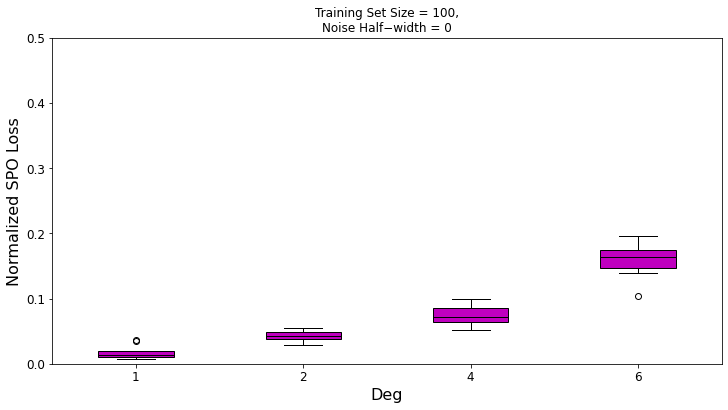

In [10]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [11]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [12]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [13]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 262.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Normalized SPO Loss: 19.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Normalized SPO Loss: 16.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 315.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Normalized SPO Loss: 13.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Normalized SPO Loss: 20.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Normalized SPO Loss: 20.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Normalized SPO Loss: 19.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Normalized SPO Loss: 16.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Normalized SPO Loss: 40.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 262.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Normalized SPO Loss: 20.82%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Normalized SPO Loss: 19.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Normalized SPO Loss: 24.48%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


Normalized SPO Loss: 23.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 159.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


Normalized SPO Loss: 20.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Normalized SPO Loss: 20.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Normalized SPO Loss: 18.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 125.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Normalized SPO Loss: 24.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 237.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Normalized SPO Loss: 21.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 341.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Normalized SPO Loss: 18.57%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Normalized SPO Loss: 22.96%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 318.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


Normalized SPO Loss: 17.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 184.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


Normalized SPO Loss: 21.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 221.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


Normalized SPO Loss: 17.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


Normalized SPO Loss: 23.69%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 97.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


Normalized SPO Loss: 22.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 235.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


Normalized SPO Loss: 20.02%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Normalized SPO Loss: 18.22%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Normalized SPO Loss: 19.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 222.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


Normalized SPO Loss: 21.96%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Normalized SPO Loss: 20.09%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


Normalized SPO Loss: 15.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Normalized SPO Loss: 15.67%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 205.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Normalized SPO Loss: 17.30%



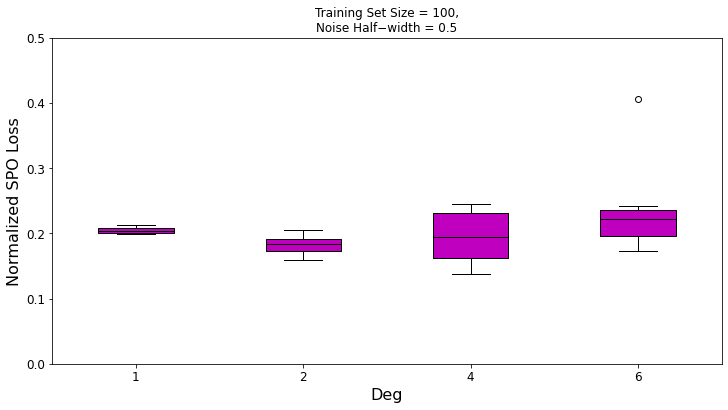

In [14]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0 

In [15]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [16]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [17]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:21<00:00, 10.72s/it]


Normalized SPO Loss: 0.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:15<00:00, 10.52s/it]


Normalized SPO Loss: 2.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:28<00:00, 10.94s/it]


Normalized SPO Loss: 5.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:56<00:00,  9.87s/it]


Normalized SPO Loss: 8.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.46it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:01<00:00, 10.06s/it]


Normalized SPO Loss: 0.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:31<00:00, 11.04s/it]


Normalized SPO Loss: 3.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:59<00:00,  9.98s/it]


Normalized SPO Loss: 7.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:20<00:00, 10.67s/it]


Normalized SPO Loss: 16.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:16<00:00, 10.54s/it]


Normalized SPO Loss: 0.90%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:52<00:00,  7.75s/it]


Normalized SPO Loss: 1.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.47it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.39s/it]


Normalized SPO Loss: 4.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:47<00:00,  9.59s/it]


Normalized SPO Loss: 8.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 246.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [07:15<00:00, 14.50s/it]


Normalized SPO Loss: 0.79%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [06:11<00:00, 12.39s/it]


Normalized SPO Loss: 2.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:46<00:00, 11.55s/it]


Normalized SPO Loss: 6.93%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [07:37<00:00, 15.26s/it]


Normalized SPO Loss: 9.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [06:04<00:00, 12.14s/it]


Normalized SPO Loss: 0.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [06:52<00:00, 13.75s/it]


Normalized SPO Loss: 2.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:56<00:00, 11.90s/it]


Normalized SPO Loss: 6.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:50<00:00, 11.70s/it]


Normalized SPO Loss: 7.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [06:03<00:00, 12.12s/it]


Normalized SPO Loss: 0.69%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.40it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:44<00:00, 11.50s/it]


Normalized SPO Loss: 1.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.07it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:48<00:00, 11.62s/it]


Normalized SPO Loss: 7.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:55<00:00, 11.86s/it]


Normalized SPO Loss: 12.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:42<00:00, 11.40s/it]


Normalized SPO Loss: 1.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 282.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.46it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:36<00:00, 11.21s/it]


Normalized SPO Loss: 2.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:23<00:00, 10.79s/it]


Normalized SPO Loss: 8.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:59<00:00,  9.98s/it]


Normalized SPO Loss: 11.75%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:18<00:00, 10.60s/it]


Normalized SPO Loss: 0.90%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:16<00:00, 10.55s/it]


Normalized SPO Loss: 2.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:00<00:00, 10.01s/it]


Normalized SPO Loss: 9.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:56<00:00,  9.88s/it]


Normalized SPO Loss: 10.56%



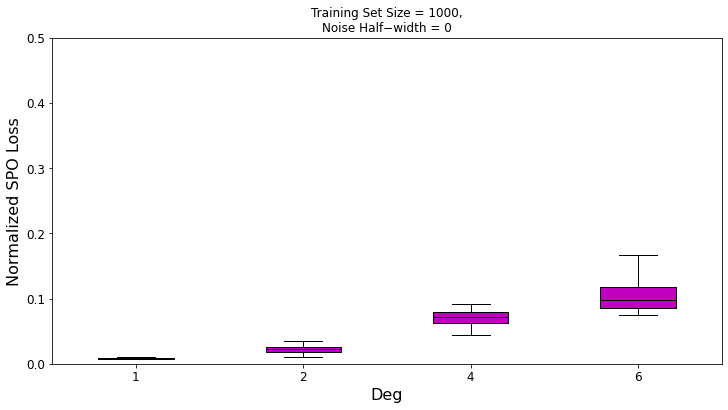

In [18]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0.5 

In [19]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [20]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [21]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:43<00:00,  7.45s/it]


Normalized SPO Loss: 20.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:29<00:00,  6.99s/it]


Normalized SPO Loss: 16.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:07<00:00,  8.23s/it]


Normalized SPO Loss: 18.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:21<00:00,  6.72s/it]


Normalized SPO Loss: 18.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:02<00:00,  8.10s/it]


Normalized SPO Loss: 22.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:13<00:00,  8.43s/it]


Normalized SPO Loss: 17.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:21<00:00,  6.72s/it]


Normalized SPO Loss: 22.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:15<00:00,  6.50s/it]


Normalized SPO Loss: 21.34%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:15<00:00,  6.52s/it]


Normalized SPO Loss: 20.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:07<00:00,  6.26s/it]


Normalized SPO Loss: 16.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.78it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:58<00:00,  7.95s/it]


Normalized SPO Loss: 17.61%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:54<00:00,  9.83s/it]


Normalized SPO Loss: 35.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:37<00:00, 11.25s/it]


Normalized SPO Loss: 21.02%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:44<00:00,  9.48s/it]


Normalized SPO Loss: 18.79%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.06it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:53<00:00,  7.79s/it]


Normalized SPO Loss: 18.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:12<00:00,  8.41s/it]


Normalized SPO Loss: 23.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.32it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:03<00:00,  8.13s/it]


Normalized SPO Loss: 20.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:22<00:00,  8.75s/it]


Normalized SPO Loss: 15.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:49<00:00, 11.64s/it]


Normalized SPO Loss: 13.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.69it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:47<00:00, 11.59s/it]


Normalized SPO Loss: 13.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:26<00:00, 10.89s/it]


Normalized SPO Loss: 22.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:32<00:00, 11.08s/it]


Normalized SPO Loss: 18.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.29it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:53<00:00, 11.78s/it]


Normalized SPO Loss: 17.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:13<00:00, 10.45s/it]


Normalized SPO Loss: 24.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.18it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [06:10<00:00, 12.33s/it]


Normalized SPO Loss: 20.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:39<00:00, 11.33s/it]


Normalized SPO Loss: 21.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:43<00:00, 11.46s/it]


Normalized SPO Loss: 16.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:32<00:00, 11.08s/it]


Normalized SPO Loss: 16.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:44<00:00, 11.49s/it]


Normalized SPO Loss: 17.69%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:32<00:00, 11.10s/it]


Normalized SPO Loss: 22.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 212.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:32<00:00, 11.08s/it]


Normalized SPO Loss: 14.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [05:47<00:00, 11.57s/it]


Normalized SPO Loss: 22.39%



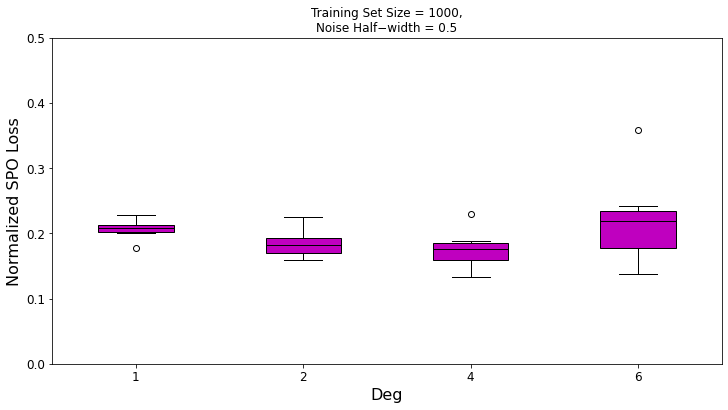

In [22]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [23]:
df1.to_csv('./res/sp/blackbox_n100.csv', index=False)
df2.to_csv('./res/sp/blackbox_n100_noise.csv', index=False)
df3.to_csv('./res/sp/blackbox_n1000.csv', index=False)
df4.to_csv('./res/sp/blackbox_n1000_noise.csv', index=False)